In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.window import Window

from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF, StopWordsRemover

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import warnings

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
%%capture
# spark = SparkSession.builder.enableHiveSupport().appName('BDP-Data-Viz').getOrCreate()
# spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark = sparknlp.start()

In [4]:
df = spark.read.csv("gs://bdp_group6_bckt_2/data/processed_data/processed_data.parquet",
                    inferSchema=True, header=True,
                    multiLine=True, quote='\"', escape='\"')
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- body_text: string (nullable = false)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)



## Most common sources of the papers:

In [5]:
sources = df.select(F.split(F.col("source_x"), "; ").alias("source_distinct"))
sources = sources.select("*", F.explode("source_distinct").alias("source"))
sources = sources.groupBy("source").count().orderBy("count", ascending=False).toPandas()
sources.head(5)

,source,count
0,PMC,563862
1,Medline,451957
2,WHO,156117
3,Elsevier,100271
4,MedRxiv,15714


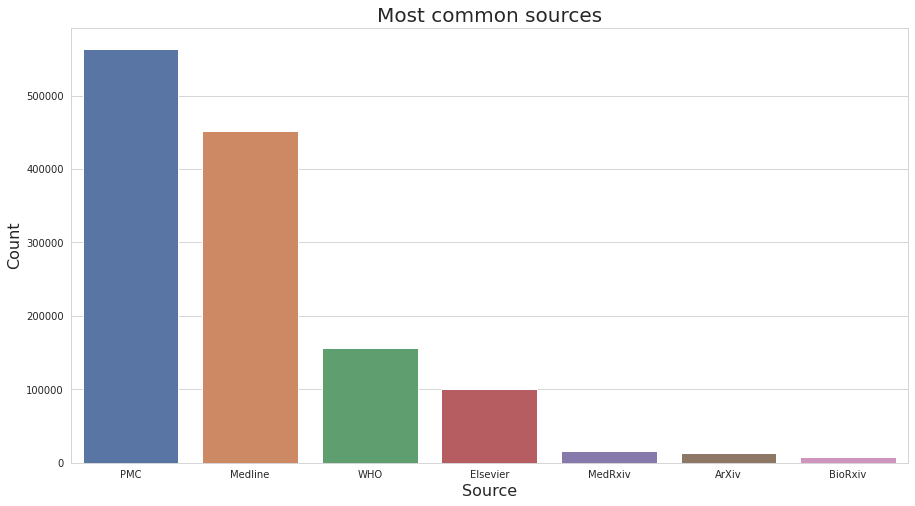

In [6]:
plt.figure(figsize=(15, 8))

sns.barplot(x="source", y="count", data=sources, palette="deep")

plt.xlabel('Source', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Most common sources', fontsize=20)

plt.show()

## Top 5 most common journals of the papers:

In [17]:
journals = df.groupBy("journal").count().orderBy(["count"],ascending = [0]).toPandas()
journals.head(5)

,journal,count
0,None,31211
1,Int J Environ Res Public Health,14176
2,PLoS One,13484
3,Sci Rep,7652
4,bioRxiv,7592


In [22]:
# About ~31k papers have missing journals
journals = journals[journals.journal != "None"]
print("Total number of journals:", len(journals))

Total number of journals: 15065


In [27]:
# There are more than 15 thousand journals. We'll plot the top20 ones
journals = journals.head(20)

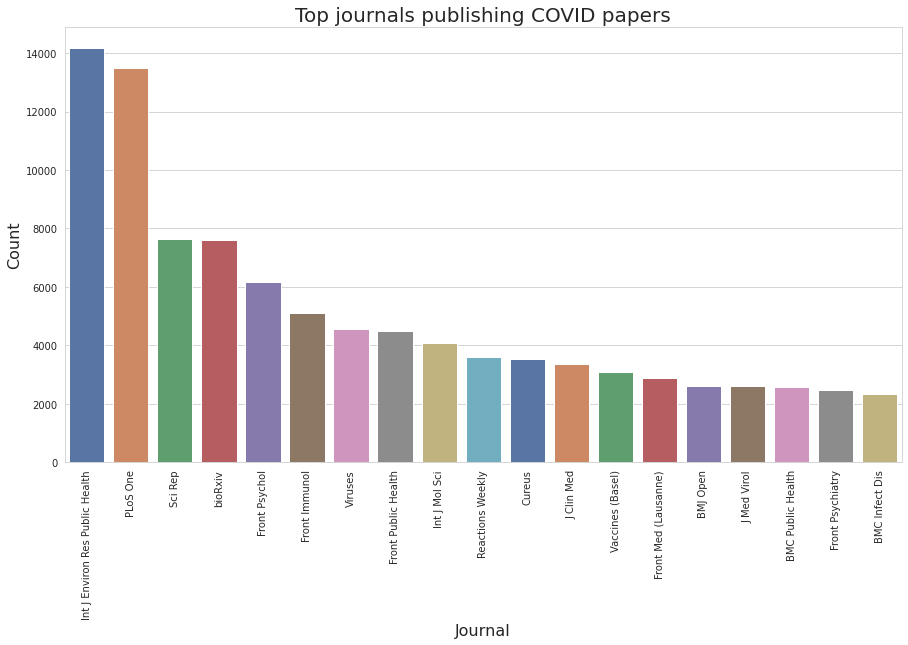

In [29]:
plt.figure(figsize=(15, 8))

sns.barplot(x="journal", y="count", data=journals, palette="deep")

plt.xlabel('Journal', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Top 20 journals publishing COVID papers', fontsize=20)
plt.xticks(rotation=90)

plt.show()

## Top authors who are doing research on COVID

In [38]:
authors = df.select(F.col("paper_id"), F.split(F.col("authors"), "; ").alias("authors_split"))
authors = authors.select("*", F.explode("authors_split").alias("authors_distinct"))
authors.select("paper_id", "authors_distinct").show(10, truncate=False)

+----------------------------------------+-----------------------+
|paper_id                                |authors_distinct       |
+----------------------------------------+-----------------------+
|0000b6da665726420ab8ac9246d526f2f44d5943|Yang, Alex             |
|0000b6da665726420ab8ac9246d526f2f44d5943|Lewis, Robert J.       |
|0000b6da665726420ab8ac9246d526f2f44d5943|Watson, Nora           |
|0000b6da665726420ab8ac9246d526f2f44d5943|Riley, Charles A.      |
|0000b6da665726420ab8ac9246d526f2f44d5943|Tolisano, Anthony M.   |
|0000b93c66f991236db92dc16fa6db119b27ca12|George, Biju           |
|0000b93c66f991236db92dc16fa6db119b27ca12|Bhattacharya, Sanjay   |
|000122a9a774ec76fa35ec0c0f6734e7e8d0c541|Rodríguez-Leor, Oriol  |
|000122a9a774ec76fa35ec0c0f6734e7e8d0c541|Cid-Álvarez, Belén     |
|000122a9a774ec76fa35ec0c0f6734e7e8d0c541|Pérez de Prado, Armando|
+----------------------------------------+-----------------------+
only showing top 10 rows



<b>NOTE: No unique id is given to any author and hence it's not possible to distinguish between two authors of the same name. For the purpose of this analysis, we'll assume that all authors with the same name are the same person.</b>

<b>TODO: Try to distinguish them on the basis of their email ids (if available), affiliations (if available), and co-author network.</b>

In [39]:
authors_explore = authors.groupBy("authors_distinct").count().orderBy("count", ascending=False).toPandas()
print("Total number of authors:", len(authors_explore))
authors_explore.head()

Total number of authors: 1361214


,authors_distinct,count
0,"Wang, Wei",715
1,"Zhang, Wei",585
2,"Wang, Jing",515
3,"Liu, Yang",514
4,"Li, Yan",505


In [40]:
# There are more than a million authors. We'll plot the top20 ones
authors_explore = authors_explore.head(20)

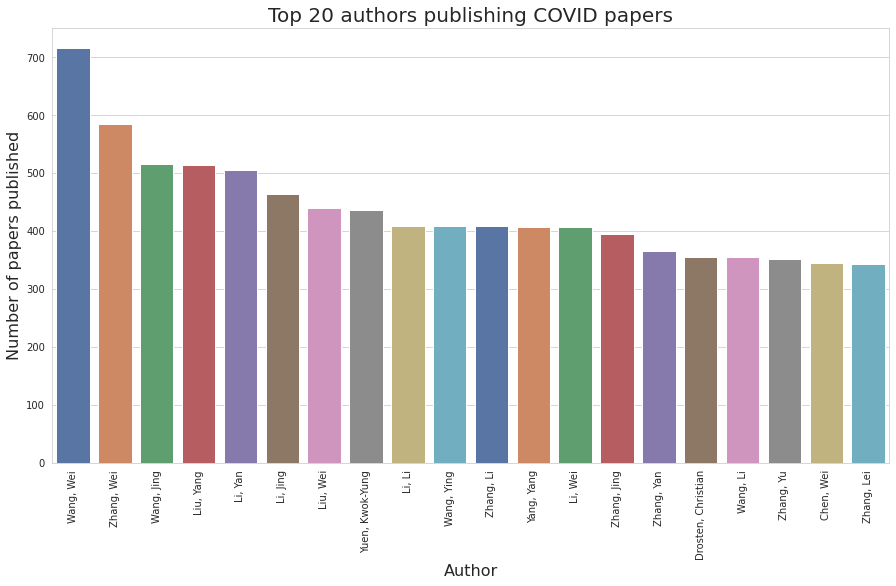

In [41]:
plt.figure(figsize=(15, 8))

sns.barplot(x="authors_distinct", y="count", data=authors_explore, palette="deep")

plt.xlabel('Author', fontsize=16)
plt.ylabel('Number of papers published', fontsize=16)
plt.title('Top 20 authors publishing COVID papers', fontsize=20)
plt.xticks(rotation=90)

plt.show()

## Number of papers by publication year

In [15]:
df = df.withColumn('year', F.year(F.col('publish_time')))
pub_year = df.groupBy("year").count().orderBy(["year"], ascending=True).toPandas()

pub_year.head(5)

,year,count
0,1950,1
1,1955,1
2,1956,1
3,1957,1
4,1963,1


In [56]:
pub_year.tail(5)

,year,count
56,2019,8214
57,2020,158996
58,2021,262827
59,2022,104572
60,2024,1


In [57]:
# Interestingly, there are papers going all the way to 1950s in this dataset. Some manual analysis reveals
# that while most of them are falsely included in the dataset, there was some research being done on SARSr-CoV
# in 2000s
pub_year = pub_year.tail(20)

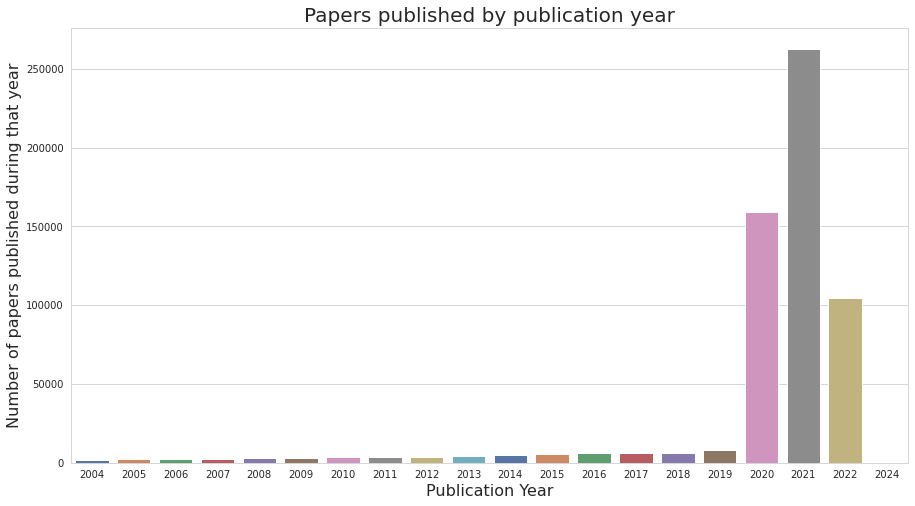

In [58]:
plt.figure(figsize=(15, 8))

sns.barplot(x="year", y="count", data=pub_year, palette="deep")

plt.xlabel('Publication Year', fontsize=16)
plt.ylabel('Number of papers published during that year', fontsize=16)
plt.title('Papers published by publication year', fontsize=20)

plt.show()

## Word Cloud of the three years with the most publications

In [61]:
def remove_stopwords(x):    
    from nltk.corpus import stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    new_stopwords = ["covid-19", "pandemic", "sars-cov-2", "health", "patients", "study", "covid-19:"]
    stopwords.extend(new_stopwords)
    
    sw = stopwords
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)
df = df.withColumn('cleaned_abstract', nosw('abstract'))

In [6]:
df = df.filter("abstract != 'None'")

In [37]:
eng_stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["covid-19", "pandemic", "sars-cov-2", "health", "patients", "study", "covid-19:", "method",
                 "covid", "use", "using", "results", "resulting", "data", "high", "higher", "p", "la"]
eng_stopwords.extend(new_stopwords)

def create_pipeline(column):
    documentAssembler = DocumentAssembler() \
         .setInputCol(column) \
         .setOutputCol('document')

    tokenizer = Tokenizer() \
         .setInputCols(['document']) \
         .setOutputCol('token')

    normalizer = Normalizer() \
         .setInputCols(['token']) \
         .setOutputCol('normalized') \
         .setLowercase(True)

    stopwords_cleaner = StopWordsCleaner() \
         .setInputCols(['normalized']) \
         .setOutputCol('clean_normalized') \
         .setCaseSensitive(False) \
         .setStopWords(eng_stopwords)

    lemmatizer = LemmatizerModel.pretrained() \
         .setInputCols(['clean_normalized']) \
         .setOutputCol('lemma')

    finisher = Finisher() \
        .setInputCols(["lemma"]) \
        .setOutputCols(["tokens"]) \
        .setOutputAsArray(True) \
        .setCleanAnnotations(False)

    pipeline = Pipeline() \
         .setStages([
               documentAssembler,
               tokenizer,
               normalizer,
               stopwords_cleaner,
               lemmatizer,
               finisher
         ])
    
    return pipeline

In [28]:
pipeline = create_pipeline("abstract")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [29]:
abstract_model = pipeline.fit(df)
abstract_df  = abstract_model.transform(df)

abstract_df = abstract_df.select("paper_id", "year", "tokens", "abstract").withColumnRenamed("tokens", "cleaned_abstract")
abstract_df.show(5)

+--------------------+----+--------------------+--------------------+
|            paper_id|year|    cleaned_abstract|            abstract|
+--------------------+----+--------------------+--------------------+
|0000b6da665726420...|2021|[objective, homet...|Objective: An at ...|
|0000b93c66f991236...|2021|[infection, hemat...|Infections in pat...|
|000122a9a774ec76f...|2020|[introduction, ob...|Introduction and ...|
|00013694fb8095bb8...|2021|[prolonged, covid...|Prolonged Covid-1...|
|0001418189999fea7...|2007|[feline, infectio...|Feline infectious...|
+--------------------+----+--------------------+--------------------+
only showing top 5 rows



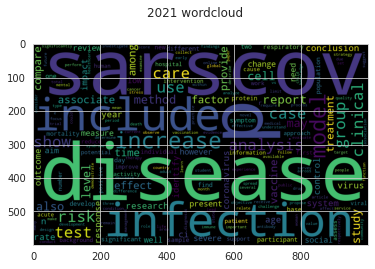

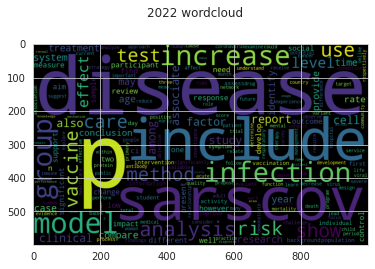

In [30]:
def flat_list(column):
    corpus = []
    for row in column:
        for w in row:
            corpus.append(w)
    return corpus

def corpus_creator(text_col):
    corpus = text_col.rdd \
                    .flatMap(flat_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF() \
                    .withColumnRenamed('_1','abstract') \
                    .withColumnRenamed('_2','count')
    return corpus

def annual_corpus(df, year):
    annual_corpus = df.select('cleaned_abstract') \
                        .filter('year=={}'.format(year)) \
                        .withColumnRenamed('cleaned_abstract','abstract')
    return annual_corpus

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['abstract']] = row['count']
        
    wordcloud = WordCloud(width=1000, height=600).generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);


years_list = [2021, 2022]

annual_corpora = {}
for year in years_list:
    annual_corpora[str(year)] = corpus_creator(annual_corpus(abstract_df, year))

for key,value in annual_corpora.items():
    fig, ax = plt.subplots()
    ax = wordcloud(value)
    fig.suptitle('{} wordcloud'.format(key))


In [42]:
abstract_df = abstract_df.select('cleaned_abstract').filter('year==2021').withColumnRenamed('cleaned_abstract', 'abstract')
abstract_count = abstract_df.select(F.explode(F.col("abstract")).alias("words")).groupby("words").count().orderBy("count", ascending=False)
abstract_count = abstract_count.toPandas()
abstract_count = abstract_count[abstract_count["count"] > 20]
abstract_count.head()

+---------+------+
|    words| count|
+---------+------+
|  disease|152203|
|  sarscov|146577|
|        p|136090|
|infection|119718|
|  include|112407|
+---------+------+
only showing top 5 rows



In [56]:
corpus_dict = dict(zip(abstract_count.words, abstract_count["count"]))

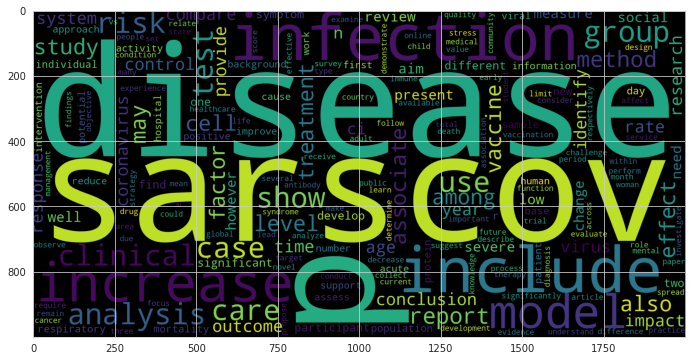

In [58]:
plt.figure(figsize=(15, 6))
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(corpus_dict)
plt.imshow(wordcloud)
plt.show()